# Map-reduce

In [13]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [14]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [15]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

In [16]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
fact_prompt = """Share an interesting and scientifically accurate cosmic fact about {subject}.
Make it engaging, clear, and educational."""
best_fact_prompt = best_fact_prompt = """Below are several cosmic facts about {topic}.
Select the most interesting, accurate, and awe-inspiring one!
Return the ID of the best fact, starting 0 as the ID for the first fact.
Facts:
{facts}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

### Parallelizing fact generation



In [17]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestFact(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    facts: Annotated[list, operator.add]
    best_selected_fact: str

In [18]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [19]:
from langgraph.types import Send
def continue_to_facts(state: OverallState):
    return [Send("generate_fact", {"subject": s}) for s in state["subjects"]]

### Fact generation (map)



In [20]:
class FactState(TypedDict):
    subject: str

class Fact(BaseModel):
    fact: str

def generate_fact(state: FactState):
    prompt = fact_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Fact).invoke(prompt)
    return {"facts": [response.fact]}

### Best fact selection (reduce)

In [21]:
def best_fact(state: OverallState):
    facts = "\n\n".join(state["facts"])
    prompt = best_fact_prompt.format(topic=state["topic"], facts=facts)
    response = model.with_structured_output(BestFact).invoke(prompt)
    return {"best_selected_fact": state["facts"][response.id]}

## Compile

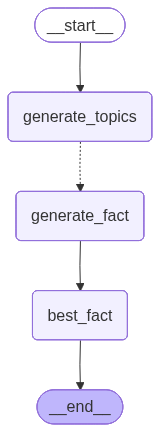

In [22]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_fact", generate_fact)
graph.add_node("best_fact", best_fact)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_facts, ["generate_fact"])
graph.add_edge("generate_fact", "best_fact")
graph.add_edge("best_fact", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [24]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "celestial bodies"}):
    print(s)

{'generate_topics': {'subjects': ['Exoplanets and Their Potential for Supporting Life', 'The Lifecycle of Stars: From Birth to Supernova', 'The Role of Dark Matter in Galaxy Formation']}}
{'generate_fact': {'facts': ['### The Enigmatic World of Exoplanets: A Glimpse into Potential Life Beyond Earth\n\nIn the vast expanse of the universe, exoplanets—planets that orbit stars outside our solar system—offer a tantalizing glimpse into the potential for life beyond Earth. Among the thousands of exoplanets discovered, some reside in the "habitable zone," a region around a star where conditions might be just right for liquid water to exist on a planet\'s surface. This is often referred to as the "Goldilocks Zone," where conditions are neither too hot nor too cold, but just right for life as we know it.\n\n#### A Cosmic Symphony of Diversity\nExoplanets come in a dazzling array of sizes, compositions, and orbits. From gas giants larger than Jupiter to rocky Earth-like planets, the diversity is 